# Introduction to the Attention Mechanism

Attention is a mechanism that allows models to focus on different parts of an input sequence when producing each output. It was originally developed for sequence-to-sequence models in natural language processing, but it's now used across many domains, including chemistry and materials science.

You can think of attention as a **soft lookup**: instead of choosing a single input token to focus on, the model takes a weighted average of all inputs.

We’ll start by implementing a simple **scaled dot-product attention** module from scratch using NumPy.

## Scaled Dot-Product Attention

Given:
- Query matrix **Q**
- Key matrix **K**
- Value matrix **V**

The attention output is computed as:

$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$

Where $ d_k $ is the dimension of the key vectors.

Intuition:
- Compute similarity between each query and all keys
- Use these similarities to weight the values

Let's implement this using `numpy`

In [1]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # for numerical stability
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# Set dimensions
d_k = 4  # dimension of keys/queries
seq_len = 3

# Random example: 3 tokens with 4-dimensional embeddings
np.random.seed(0)
Q = np.random.rand(seq_len, d_k)
K = np.random.rand(seq_len, d_k)
V = np.random.rand(seq_len, d_k)

# Attention calculation
scores = Q @ K.T / np.sqrt(d_k)     # (3, 3) matrix of attention scores
weights = softmax(scores)           # (3, 3) attention weights
output = weights @ V                # weighted sum of values

print("Attention weights:\n", weights)
print("\nOutput:\n", output)

Attention weights:
 [[0.26820899 0.341926   0.38986501]
 [0.25100881 0.35895866 0.39003253]
 [0.25670316 0.31516267 0.42813417]]

Output:
 [[0.38799283 0.53502878 0.13623257 0.75889379]
 [0.39492337 0.53118004 0.1382761  0.75593604]
 [0.39012207 0.53832171 0.12822185 0.75093991]]


## Understanding `attention_block`: Scaled Dot-Product Self-Attention in NumPy

The `attention_block` function implements **scaled dot-product self-attention** — the core mechanism behind transformer models.

### Steps:

1. **Linear Projections**:  
   We project the input $ X $ into three new matrices:
   - $ Q = X W_Q $
   - $ K = X W_K $
   - $ V = X W_V $

   Where:
   - $ W_Q, W_K, W_V \in \mathbb{R}^{d_{\text{model}} \times d_k} $ are learned projection matrices
   - $ d_k $ is typically smaller than $ d_{\text{model}} $ (but can be equal)

2. **Similarity Scores**:  
   Compute dot products between all query-key pairs:

   $
   \text{scores} = \frac{Q K^T}{\sqrt{d_k}}
   $

   This gives an $ L \times L $ matrix where each entry represents how much a token should "attend" to another token.

3. **Softmax**:  
   Normalize scores to get **attention weights**:

   $
   \alpha_{ij} = \frac{\exp(\text{score}_{ij})}{\sum_k \exp(\text{score}_{ik})}
   $

   Each row of this matrix sums to 1 — it's a weighted distribution over the input tokens.

4. **Weighted Sum of Values**:  
   Multiply the attention weights by the value matrix:

   $
   \text{Output} = \alpha V
   $

   The output is a new representation for each token, where information from the entire sequence has been blended based on relevance.

---

### Function Signature

```python
attention_block(X, d_k=None, W_q=None, W_k=None, W_v=None)

In [61]:
def attention_block(X, d_k=None, W_q=None, W_k=None, W_v=None):
    """
    Compute scaled dot-product self-attention.

    Parameters:
    - X: np.ndarray of shape (seq_len, d_model) — input embeddings
    - d_k: optional int — dimension of Q/K/V projections (default = input dim)
    - W_q, W_k, W_v: optional projection matrices of shape (d_model, d_k)

    Returns:
    - output: np.ndarray of shape (seq_len, d_k)
    - weights: attention weight matrix of shape (seq_len, seq_len)
    """
    seq_len, d_model = X.shape
    d_k = d_k or d_model  # default to identity if not projecting

    # If no projections provided, use random ones
    if W_q is None: W_q = np.random.rand(d_model, d_k)
    if W_k is None: W_k = np.random.rand(d_model, d_k)
    if W_v is None: W_v = np.random.rand(d_model, d_k)

    # Project inputs
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v

    # Scaled dot-product attention
    scores = Q @ K.T / np.sqrt(d_k)        # Shape: (seq_len, seq_len)
    weights = softmax(scores)              # Shape: (seq_len, seq_len)
    output = weights @ V                   # Shape: (seq_len, d_k)

    return output, weights

In [62]:
# Run it on dummy data
X = np.random.rand(3, 8)  # 3 tokens with 8-dim embeddings
out, attn_weights = attention_block(X, d_k=4)

print("Attention Output:\n", out)

Attention Output:
 [[2.87005184 1.55292328 2.42882148 2.67045462]
 [2.92223142 1.57049124 2.44608424 2.71084302]
 [2.91141194 1.56296695 2.44806933 2.70404478]]


### Visualise the results

We can visualise the attention matrix, which controls how much the tokens affect one another. Remember that at this stage the attention matrix is random. During training the model would learn the weights of this matrix.

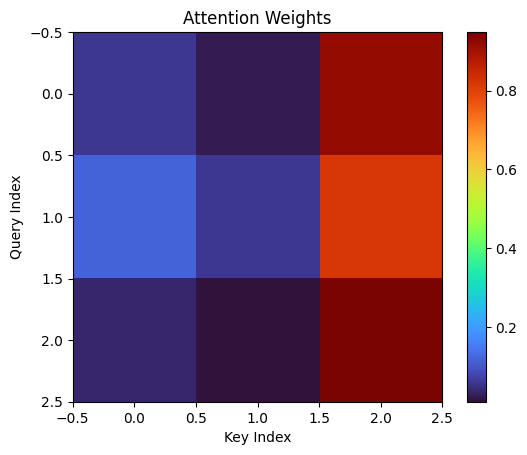

In [10]:
import matplotlib.pyplot as plt

def plot_attention(weights, title="Attention Weights"):
    plt.imshow(weights, cmap='turbo')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Key Index")
    plt.ylabel("Query Index")
    plt.show()

plot_attention(attn_weights)

## Attention with words

Let's make that a little bit more concrete by implementing attention for a sentence. In this case we have a simple 6 word sentence with 5 different words. We will use a rudimentary tokenizing scheme whereby each word is allocated a number, corresponding to where it first occurs in the sentence

In [5]:
# 1. Tokenize the sentence
sentence = "The cat sat on the mat"
tokens = sentence.lower().split()
vocab = list(set(tokens))  # Unique tokens
vocab_size = len(vocab)
token_to_id = {tok: i for i, tok in enumerate(vocab)}

# Map sentence to token IDs
token_ids = np.array([token_to_id[tok] for tok in tokens])
print("Token IDs:", token_ids)

Token IDs: [3 2 4 1 3 0]


### Setting up the embedding matrix

The embedding matrix will determine the dimensionality of the tokens within the attention block.

In [66]:
# 2. Create random embeddings
embedding_dim = 8
np.random.seed(3)
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# Get the embedded sentence
X = embedding_matrix[token_ids]  # Shape: (seq_len, embedding_dim)
print("Embedded shape:", X.shape)

Embedded shape: (6, 8)


In [67]:
def attention_block(X, d_k=None, W_q=None, W_k=None, W_v=None):
    """
    Compute scaled dot-product self-attention.

    Parameters:
    - X: np.ndarray of shape (seq_len, d_model) — input embeddings
    - d_k: optional int — dimension of Q/K/V projections (default = input dim)
    - W_q, W_k, W_v: optional projection matrices of shape (d_model, d_k)

    Returns:
    - output: np.ndarray of shape (seq_len, d_k)
    - weights: attention weight matrix of shape (seq_len, seq_len)
    """
    seq_len, d_model = X.shape
    print(seq_len)
    d_k = d_k or d_model  # default to identity if not projecting

    # If no projections provided, use random ones
    if W_q is None: W_q = np.random.rand(d_model, d_k)
    if W_k is None: W_k = np.random.rand(d_model, d_k)
    if W_v is None: W_v = np.random.rand(d_model, d_k)

    # Project inputs
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v

    # Scaled dot-product attention
    scores = Q @ K.T / np.sqrt(d_k)        # Shape: (seq_len, seq_len)
    weights = softmax(scores)              # Shape: (seq_len, seq_len)
    update = weights @ V                   # Shape: (seq_len, d_k)
    output = update + X
    return output, weights

In [68]:
out, attn_weights = attention_block(X, d_k=embedding_dim)

6


### Visualise the attention matrix

We can visualise the attention matrix, which controls how much the tokens affect one another. Remember that at this stage the attention matrix is random. During training the model would learn the weights of this matrix.

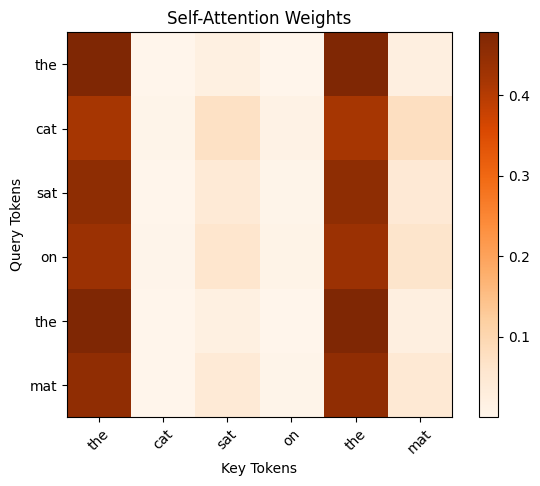

In [69]:
def plot_attention_tokens(weights, tokens):
    plt.figure(figsize=(7, 5))
    plt.imshow(weights, cmap='Oranges')
    plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=45)
    plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
    plt.colorbar()
    plt.title("Self-Attention Weights")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

plot_attention_tokens(attn_weights, tokens)

### Visualise the effect of attention

The attention matrix tells us how one token in a sequence updates another. In order to visualise this we can plot the token vectors before and after passing through the attention block. 

In [70]:
def plot_input_output(X, out, tokens=None, title="Input vs Attention Output"):
    """
    Plots the input and output embeddings side by side as heatmaps.

    Parameters:
    - X: input array (seq_len, dim)
    - out: output from attention (seq_len, dim)
    - tokens: optional list of token labels for y-axis
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot input embeddings
    im0 = axs[0].imshow(X, aspect='auto', cmap='Blues')
    axs[0].set_title("Input Embeddings")
    axs[0].set_xlabel("Embedding Dim")
    axs[0].set_ylabel("Token")
    if tokens:
        axs[0].set_yticks(range(len(tokens)))
        axs[0].set_yticklabels(tokens)
    fig.colorbar(im0, ax=axs[0])

    # Plot attention output
    im1 = axs[1].imshow(out, aspect='auto', cmap='Blues')
    axs[1].set_title("Output Embeddings (after Attention)")
    axs[1].set_xlabel("Embedding Dim")
    axs[1].set_ylabel("Token")
    if tokens:
        axs[1].set_yticks(range(len(tokens)))
        axs[1].set_yticklabels(tokens)
    fig.colorbar(im1, ax=axs[1])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

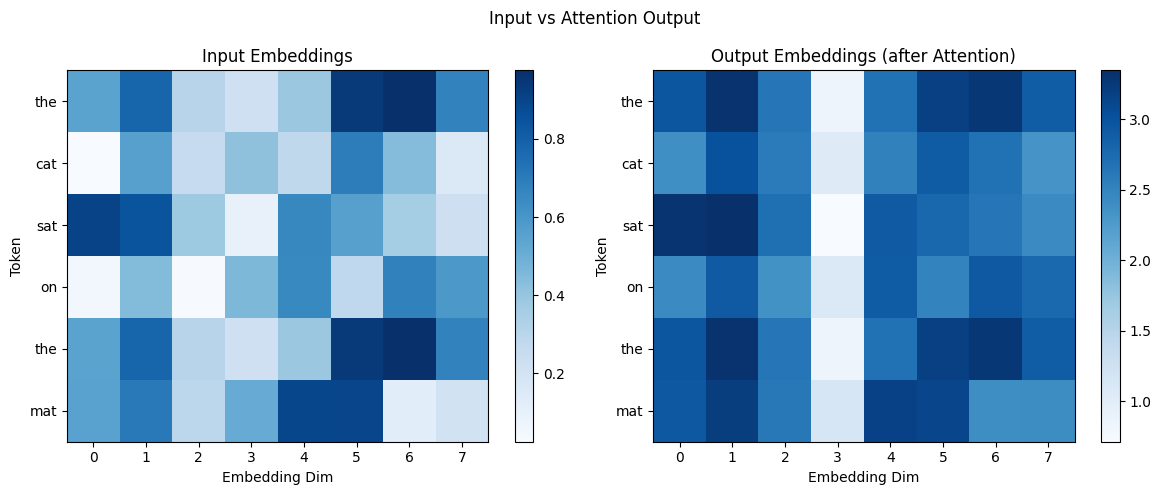

In [71]:
plot_input_output(X, out, tokens=tokens)

## Why is Attention Powerful?

- It lets the model decide **what to look at** in the input when processing each token.
- It allows **long-range dependencies** (e.g. token 1 can directly interact with token 50).
- It’s **parallelizable** across all positions (unlike RNNs).

This is the foundation of the **Transformer architecture**, where multiple attention heads are used in parallel.

In later notebooks, we’ll see how this mechanism is used in CrystaLLM for crystal generation and materials modeling.